In [1]:
import yfinance as yf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import tqdm
import re
import random

from sklearn.metrics import mean_squared_error

print('Is CUDA available ?', torch.cuda.is_available())
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Is CUDA available ? True


In [2]:
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [3]:
def RS_vol(data):
    first_element = np.log(data['最高價(元)'].astype(float))-np.log(data['開盤價(元)'].astype(float))
    second_element = np.log(data['最高價(元)'].astype(float))-np.log(data['收盤價(元)'].astype(float))
    third_element = np.log(data['最低價(元)'].astype(float))-np.log(data['開盤價(元)'].astype(float))
    fouth_element = np.log(data['最低價(元)'].astype(float))-np.log(data['收盤價(元)'].astype(float))
    volatility_rs = first_element*second_element+third_element*fouth_element
    return volatility_rs

In [40]:
nodes = pd.read_excel("Total_Network.xlsx", header = None).iloc[:, 2].str.replace(".TW", "").to_list()
company_data = pd.read_excel("價格_籌碼資料.xlsx")
company_data = company_data.set_index('Unnamed: 0')
#company_data

In [41]:
data = dict()
rolling_days = 20

interest_rate = yf.download("^TNX", start = '2018-06-01')['Close']
VIX = yf.download("^VIX", start = '2018-06-01')['Close']
USDTWD = yf.download("USDTWD=X", start = '2018-06-01')['Close']

for comp in nodes:
    if comp == "6669" or comp == "5876":
        continue
    
    company = company_data.filter(like = comp)
    company.columns = company.iloc[0]
    # 調整 columns name，所以從第一 row 開始取
    company = company.iloc[1:]
    feature = pd.DataFrame()
    company['收盤價(元)'] = company['收盤價(元)'].astype(float)
    feature['log return'] = np.log(company['收盤價(元)'] / company['收盤價(元)'].shift(1))
    feature['rsvol'] = RS_vol(company)
    feature['trading shares / total shares outstanding'] = company['成交量(千股)'] / company['流通在外股數(千股)']
    feature['foreign'] = company['外資買賣超(張)'] / (abs(company['外資買賣超(張)'].rolling(rolling_days).mean()) + 1)
    feature['investment bank'] = company['投信買賣超(張)'] / (abs(company['投信買賣超(張)'].rolling(rolling_days).mean()) + 1)
    feature['proprietary'] = company['自營買賣超(張)'] / (abs(company['自營買賣超(張)'].rolling(rolling_days).mean()) + 1)
    feature['marginal ratio'] = company['券資比'] / (abs(company['券資比'].rolling(rolling_days).mean()) + 1)
    feature['marginal trading volume / total volume'] = company['融資(買+賣)/成交量 %']
    feature['short selling volume / total volume'] = company['融券(買+賣)/成交量 %']
    feature['day trading ratio'] = company['現沖+當沖比重']
    feature['interest rate'] = interest_rate
    feature['VIX'] = VIX
    feature['USDTWD'] = USDTWD
    data[comp] = feature.iloc[rolling_days - 1: ].fillna(method = 'ffill')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [42]:
for i in data:
    if data[i].isna().sum().sum()!=0:
        print(i, data[i].isna().sum())

In [43]:
financial_statement = pd.read_excel("財報資料.xlsx")
financial_statement = financial_statement.iloc[: -1]
financial_statement = financial_statement.set_index("Unnamed: 0", drop = True)
#financial_statement

In [44]:
financial_statement_data = dict()

data_0050 = False
count = 0
for comp in nodes:
    
    if comp == '0050':
        
        data_0050 /= count
        financial_statement_data[comp] = data_0050
        break
    
    if comp == "6669" or comp == "5876":
        continue
    
    count += 1
    company = financial_statement.filter(like = comp)
    company.columns = company.iloc[0]
    company = company.iloc[1:]
    company['稅前息前淨利'] += 1
    company['來自營運之現金流量'] = company['來自營運之現金流量'] / company['稅前息前淨利']
    company = company.drop(columns=['營業毛利率', '營業利益率', '總資產週轉次數', '存貨週轉率（次）', '應收帳款週轉次數', '稅前息前淨利'])
    company['稅前淨利率'] /= 100
    company['ROE(A)－稅後'] /= 100
    company['營收成長率'] /= 100
    company['稅後淨利成長率'] /= 100
    company = company.fillna(method = 'ffill')
    company = company.fillna(0)
    financial_statement_data[comp] = company
    
    if type(data_0050) == bool:
        data_0050 = company.copy()
    else:
        data_0050 += company.copy()
    
    
#financial_statement_data

In [9]:
class GRUGAT(nn.Module):
    def __init__(self, input_dim, gru_hidden_dim, gat_hidden_dim, output_dim, num_gru_layers, num_gat_layers, num_heads, num_financial_statement_features, bidirectional = True):
        super().__init__()
        """
        input data: batch size x sequence x features
        這個問題中 batch size 為 49，代表一支股票就是一組 data；sequence 為 previous_days
        """
        self.input_dim = input_dim
        self.gru_hidden_dim = gru_hidden_dim
        self.gat_hidden_dim = gat_hidden_dim
        self.output_dim = output_dim
        self.num_heads = num_heads
        self.gat_layers = num_gat_layers
        self.num_financial_statement_features = num_financial_statement_features
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_dim, gru_hidden_dim, num_layers=num_gru_layers, batch_first=True, bidirectional=True, dropout = 0.2)
        #self.gru = nn.LSTM(input_dim, gru_hidden_dim, num_layers=num_gru_layers, batch_first=True, bidirectional=True, dropout = 0.2)

        if bidirectional == True:
            self.gat_layers = nn.ModuleList([
                GATConv((2 * gru_hidden_dim + num_financial_statement_features) if i == 0 else gat_hidden_dim * num_heads, gat_hidden_dim, heads = num_heads, dropout = 0.2)
                for i in range(num_gat_layers)
            ])
            self.batchnorm = nn.BatchNorm1d(2 * gru_hidden_dim + num_financial_statement_features)
        else:
            self.gat_layers = nn.ModuleList([
                GATConv((gru_hidden_dim + num_financial_statement_features) if i == 0 else gat_hidden_dim * num_heads, gat_hidden_dim, heads = num_heads, dropout = 0.2)
                for i in range(num_gat_layers)
            ])
            self.batchnorm = nn.BatchNorm1d(gru_hidden_dim + num_financial_statement_features)

        #self.batchnorm_gat = nn.BatchNorm1d(gat_hidden_dim * num_heads)
        #self.batchnorm = nn.BatchNorm1d(num_financial_statement_features)
        self.predict = nn.Linear(gat_hidden_dim * num_heads, output_dim)
        self.batchnorm_fs = nn.BatchNorm1d(num_financial_statement_features)
        self.edge_weight = None
        self.edge = None
        
    def forward(self, x, edge_index):
        x = x.squeeze(0)
        numofnodes = x.shape[0]
        financial_statement_x = x[:, -1, -7:].squeeze(1)

        x = x[:, :, :-7]
        x, _ = self.gru(x)
        x = x[:, -1, :]
        if self.bidirectional:
            x = x.view(-1, numofnodes, 2 * self.gru_hidden_dim)[0] # --> 1 x 49 x time series embedded features
        else:
            x = x.view(-1, numofnodes, self.gru_hidden_dim)[0] # --> 1 x 49 x time series embedded features
        
        # concat 財報資料
        if self.num_financial_statement_features != 0:
            financial_statement_x = self.batchnorm_fs(financial_statement_x)
            x = torch.cat([x, financial_statement_x], axis = 1)
            #x = self.batchnorm(x)
        
        # Apply each GAT layer in sequence
        for gat in self.gat_layers:
            x, weight = gat(x, edge_index, return_attention_weights = True)
            self.edge_weight = weight[1]
            self.edge = weight[0]
            x = torch.relu(x)
            # x = self.batchnorm_gat(x)
            
        x = self.predict(x)
        return x
    
    def get_edge_weight(self):
        return self.edge_weight
    
    def get_edge(self):
        return self.edge

In [10]:
class GRU(nn.Module):
    def __init__(self, input_dim, gru_hidden_dim, output_dim, num_gru_layers, num_financial_statement_features, bidirectional = True):
        super().__init__()
        self.input_dim = input_dim
        self.gru_hidden_dim = gru_hidden_dim
        self.output_dim = output_dim
        self.num_financial_statement_features = num_financial_statement_features
        self.bidirectional = bidirectional
        self.gru = nn.GRU(input_dim, gru_hidden_dim, num_layers = num_gru_layers, batch_first = True, bidirectional = True, dropout = 0.2)
        #self.gru = nn.LSTM(input_dim, gru_hidden_dim, num_layers = num_gru_layers, batch_first = True, bidirectional = True, dropout = 0.2)

        if bidirectional == True:
            self.predict = nn.Linear(2 * gru_hidden_dim + num_financial_statement_features, output_dim)
            self.batchnorm = nn.BatchNorm1d(2 * gru_hidden_dim + num_financial_statement_features)

        else:
            self.predict = nn.Linear(gru_hidden_dim + num_financial_statement_features, output_dim)
            self.batchnorm = nn.BatchNorm1d(gru_hidden_dim + num_financial_statement_features)


    def forward(self, x):
        x = x.squeeze(0)
        numofnodes = x.shape[0]
        financial_statement_x = x[:, -1, -7:].squeeze(1)
        
        x = x[:, :, :-7]
        x, _ = self.gru(x)
        x = x[:, -1, :]
        if self.bidirectional:
            x = x.view(-1, numofnodes, 2 * self.gru_hidden_dim)[0] # --> 1 x 49 x time series embedded features
        else:
            x = x.view(-1, numofnodes, self.gru_hidden_dim)[0] # --> 1 x 49 x time series embedded features

        # concat 財報資料
        if self.num_financial_statement_features != 0:
            x = torch.cat([x, financial_statement_x], axis = 1) # --> 1 x 49 x (time series embedded features + financial statement features)
            x = self.batchnorm(x)

        x = self.predict(x)
        return x

In [11]:
def upload_nodes(filename):
    nodes_edges = pd.read_excel(filename, header=None)
    edge_index = []
    for i in range(nodes_edges.shape[0]):
        for j in nodes_edges.iloc[i, 3:].dropna().to_list():
            numbers = re.findall(r'-?\d+', j)
            numbers = [int(num) for num in numbers]
            start, end = numbers[0], numbers[1]

            if 38 in numbers or 43 in numbers:
                continue
            if start > 38 and start < 43:
                start -= 1
            if end > 38 and end < 43:
                end -= 1       
            if start > 43:
                start -= 2
            if end > 43:
                end -= 2
            numbers = [start, end]
            edge_index.append(numbers)
    
    return torch.tensor(edge_index, dtype = torch.long).t().to(device)

In [45]:
for comp in nodes:
    if comp == "6669" or comp == "5876":
        continue 
    data_df = data[comp].copy()
    fdata_df = financial_statement_data[comp].copy()
    data_df['date'] = data_df.index.to_list()
    fdata_df['fdate'] = fdata_df.index.to_list()
    merged_df = pd.merge_asof(data_df, fdata_df, left_on='date', right_on='fdate', direction='backward')
    merged_df = merged_df.set_index('date')
    merged_df = merged_df.drop(columns=['fdate'])
    data[comp] = merged_df
#data

In [13]:
# Hyperparameters setup
previous_days = 15
prediction_days = 5
epochs = 30
random_seed = 42

X_train = dict()
Y_train = dict()
X_test = dict()
Y_test = dict()


for comp in data:
    train = data[f"{comp}"][data[f"{comp}"].index < pd.to_datetime("2023")]
    test = data[f"{comp}"][data[f"{comp}"].index >= pd.to_datetime("2023")]
    
    x_train = train.iloc[: -prediction_days]
    y_train = train.iloc[previous_days: ]

    x_test = test.iloc[: -prediction_days]
    y_test = test.iloc[previous_days: ]
    
    x_train = x_train.to_numpy()
    x_train = np.lib.stride_tricks.as_strided(x_train, 
                                              shape=(x_train.shape[0] - previous_days + 1, previous_days, x_train.shape[1]), 
                                              strides=(x_train.strides[0], x_train.strides[0], x_train.strides[1])) 

    x_test = x_test.to_numpy()
    x_test = np.lib.stride_tricks.as_strided(x_test, 
                                              shape=(x_test.shape[0] - previous_days + 1, previous_days, x_test.shape[1]), 
                                              strides=(x_test.strides[0], x_test.strides[0], x_test.strides[1])) 

    y_train = y_train.to_numpy()
    y_train = np.lib.stride_tricks.as_strided(y_train, 
                                              shape=(y_train.shape[0] - prediction_days + 1, prediction_days, y_train.shape[1]), 
                                              strides=(y_train.strides[0], y_train.strides[0], y_train.strides[1]))
    
    
    y_test = y_test.to_numpy()
    y_test = np.lib.stride_tricks.as_strided(y_test, 
                                              shape=(y_test.shape[0] - prediction_days + 1, prediction_days, y_test.shape[1]), 
                                              strides=(y_test.strides[0], y_test.strides[0], y_test.strides[1]))

    
    y_train = y_train[:, :, 0].cumsum(axis = 1)#[:, -1]
    y_test = y_test[:, :, 0].cumsum(axis = 1)#[:, -1]
    
    X_train[f"{comp}"] = x_train
    Y_train[f"{comp}"] = y_train
    X_test[f"{comp}"] = x_test
    Y_test[f"{comp}"] = y_test


In [14]:
numofData, numofSequence, numofFeature = X_train['2330'].shape

training_x = []
training_y = []
for time in range(numofData):
    X = []
    Y = []
    for comp in data:
        X.append(X_train[comp][time])
        Y.append(Y_train[comp][time])
    X = np.array(X)
    Y = np.array(Y)
    training_x.append(X)
    training_y.append(Y)
    
training_x = np.array(training_x)
training_y = np.array(training_y)

# ---------------------------------------------------------------------------

numofData, numofSequence, numofFeature = X_test['2330'].shape

testing_x = []
testing_y = []
for time in range(numofData):
    X = []
    Y = []
    for comp in data:
        X.append(X_test[comp][time])
        Y.append(Y_test[comp][time])
    X = np.array(X)
    Y = np.array(Y)
    testing_x.append(X)
    testing_y.append(Y)
    
testing_x = np.array(testing_x)
testing_y = np.array(testing_y)

training_x.shape, training_y.shape, testing_x.shape, testing_y.shape

((1088, 49, 15, 20), (1088, 49, 5), (303, 49, 15, 20), (303, 49, 5))

In [15]:
training_x = torch.tensor(training_x, dtype = torch.float32)
training_y = torch.tensor(training_y, dtype = torch.float32)

testing_x = torch.tensor(testing_x, dtype = torch.float32)
testing_y = torch.tensor(testing_y, dtype = torch.float32)

training_dataloader = DataLoader(dataset = TensorDataset(training_x, training_y), batch_size = 1, shuffle = True)
testing_dataloader = DataLoader(dataset = TensorDataset(testing_x, testing_y), batch_size = 1, shuffle = False)

training_dataloader_noshuffle = DataLoader(dataset = TensorDataset(training_x, training_y), batch_size = 1, shuffle = False)

In [16]:
def train(model, optimizer, criterion, epochs, training_dataloader, node_filename = None):        
    loss_trajectory = []
    if type(node_filename) == str:
        node_edge = upload_nodes(node_filename)
        
    for epoch in tqdm(range(epochs)):
        Loss = 0
        model.train()
        for x, y in training_dataloader:
            x = x.to(device)
            y = y.to(device).squeeze(0)

            optimizer.zero_grad()
            if type(node_filename) == str:
                y_out = model(x, node_edge).squeeze(1)  
            else:
                y_out = model(x).squeeze(1)  

            loss = criterion(y_out, y)
            Loss += loss.item()

            loss.backward()
            optimizer.step() 

        loss_trajectory.append(Loss)
        clear_output(wait = True)
        plt.plot([i + 1 for i in range(len(loss_trajectory))], loss_trajectory)
        plt.show()
    return model

In [17]:
def test(model, criterion, testing_dataloader, node_filename = None):
    if type(node_filename) == str:
        node_edge = upload_nodes(node_filename)

    model.eval()
    #Loss = 0
    etf_pred = []
    etf_real = []
    
    Loss_list = [0] * prediction_days
    count = 0
    for x, y in testing_dataloader:
        count += 1
        x = x.to(device)
        y = y.to(device).squeeze(0)

        if type(node_filename) == str:
            y_out = model(x, node_edge).squeeze(1)  
        else:
            y_out = model(x).squeeze(1)  
        
        #loss = criterion(y_out, y)
        #Loss += loss.item()
        for i in range(prediction_days):
            loss = criterion(y_out[:, i], y[:, i])
            Loss_list[i]+=loss
            
        etf_pred.append(y_out[-1, :].cpu().detach().numpy())
        etf_real.append(y[-1, :].cpu().detach().numpy())

    #print(f"Test Loss: {round(Loss, 4)}")
    for i in range(prediction_days):
        print(f"Test loss T+{i+1}: {Loss_list[i] * 10000 / count}")
    etf_pred = np.array(etf_pred)
    etf_real = np.array(etf_real)
    return [mean_squared_error(etf_real[:, i].reshape(-1, 1), etf_pred[:, i].reshape(-1, 1)) for i in range(prediction_days)]
    

## GRUGAT

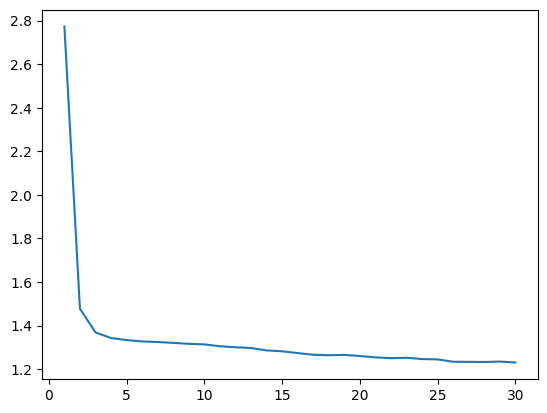

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:29<00:00, 10.99s/it]


Test loss T+1: 3.0709455013275146
Test loss T+2: 6.1756510734558105
Test loss T+3: 9.280195236206055
Test loss T+4: 12.14819049835205
Test loss T+5: 15.195131301879883


In [18]:
set_seed(random_seed)
num_financial_statement_features = 7
input_dim = training_x.shape[-1] - num_financial_statement_features

# 這行重新定義是為了控制要不要concat財報資料
num_financial_statement_features = 0
gru_hidden_dim = 10 
gat_hidden_dim = 10

output_dim = 5
num_gru_layers = 10
num_gat_layers = 2
num_heads = 2

model_complete = GRUGAT(input_dim, gru_hidden_dim, gat_hidden_dim, output_dim, num_gru_layers, num_gat_layers, num_heads, num_financial_statement_features, bidirectional = False).to(device)
optimizer = torch.optim.Adam(model_complete.parameters(), lr = 0.0001)
criterion = nn.MSELoss()

model_complete = train(model_complete, optimizer, criterion, epochs, training_dataloader, 'Total_Network.xlsx')
model_complete_test_error = test(model_complete, criterion, testing_dataloader, 'Total_Network.xlsx')
torch.save(model_complete, f'model_complete_{prediction_days}.pth')

## GRUGAT, Homogeneous Subgraph

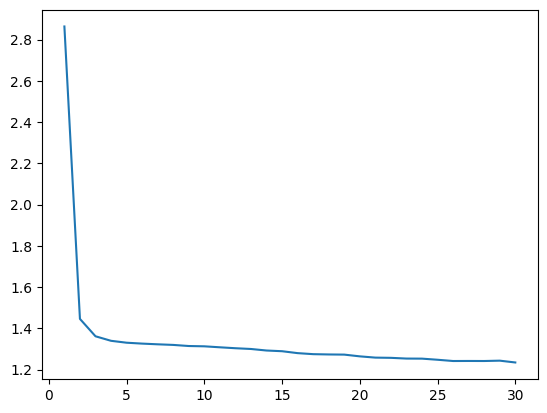

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:29<00:00, 10.97s/it]


Test loss T+1: 3.053354024887085
Test loss T+2: 6.146626949310303
Test loss T+3: 9.189481735229492
Test loss T+4: 12.033453941345215
Test loss T+5: 14.921503067016602


In [19]:
set_seed(random_seed)
num_financial_statement_features = 7
input_dim = training_x.shape[-1] - num_financial_statement_features

# 這行重新定義是為了控制要不要concat財報資料
num_financial_statement_features = 0
gru_hidden_dim = 10 
gat_hidden_dim = 10

output_dim = 5
num_gru_layers = 10
num_gat_layers = 2
num_heads = 2

model_homo = GRUGAT(input_dim, gru_hidden_dim, gat_hidden_dim, output_dim, num_gru_layers, num_gat_layers, num_heads, num_financial_statement_features, bidirectional = False).to(device)
optimizer = torch.optim.Adam(model_homo.parameters(), lr = 0.0001)
criterion = nn.MSELoss()

model_homo = train(model_homo, optimizer, criterion, epochs, training_dataloader, 'Homogeneous.xlsx')
model_homo_test_error = test(model_homo, criterion, testing_dataloader, 'Homogeneous.xlsx')
torch.save(model_homo, f'model_homo_{prediction_days}.pth')

## GRUGAT, Heterogeneous Subgraph

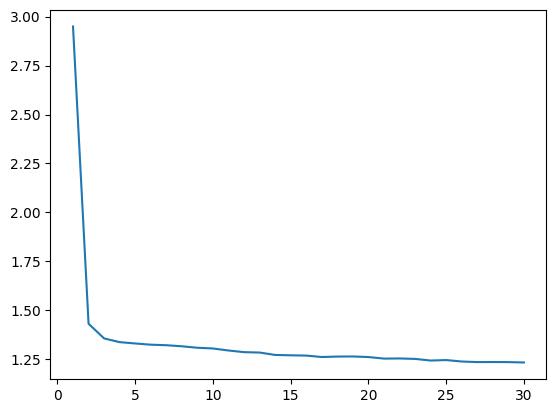

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [05:27<00:00, 10.92s/it]


Test loss T+1: 3.053631544113159
Test loss T+2: 6.136958122253418
Test loss T+3: 9.191415786743164
Test loss T+4: 12.028791427612305
Test loss T+5: 14.926663398742676


In [20]:
set_seed(random_seed)
num_financial_statement_features = 7
input_dim = training_x.shape[-1] - num_financial_statement_features

# 這行重新定義是為了控制要不要concat財報資料
num_financial_statement_features = 0
gru_hidden_dim = 10 
gat_hidden_dim = 10

output_dim = 5
num_gru_layers = 10
num_gat_layers = 2
num_heads = 2

model_hetero = GRUGAT(input_dim, gru_hidden_dim, gat_hidden_dim, output_dim, num_gru_layers, num_gat_layers, num_heads, num_financial_statement_features, bidirectional = False).to(device)
optimizer = torch.optim.Adam(model_hetero.parameters(), lr = 0.0001)
criterion = nn.MSELoss()

model_hetero = train(model_hetero, optimizer, criterion, epochs, training_dataloader, 'Heterogeneous.xlsx')
model_hetero_test_error = test(model_hetero, criterion, testing_dataloader, 'Heterogeneous.xlsx')
torch.save(model_hetero, f'model_hetero_{prediction_days}.pth')

## GRU

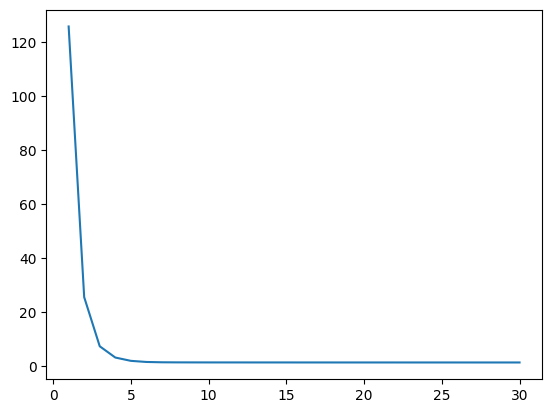

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:27<00:00,  6.92s/it]


Test loss T+1: 3.0959622859954834
Test loss T+2: 6.501664161682129
Test loss T+3: 9.898177146911621
Test loss T+4: 12.809334754943848
Test loss T+5: 15.571407318115234


In [21]:
set_seed(random_seed)
num_financial_statement_features = 7
input_dim = training_x.shape[-1] - num_financial_statement_features

# 這行重新定義是為了控制要不要concat財報資料
num_financial_statement_features = 7
gru_hidden_dim = 10 
gat_hidden_dim = 10

output_dim = 5
num_gru_layers = 10
num_gat_layers = 2
num_heads = 2

model_gru = GRU(input_dim, gru_hidden_dim, output_dim, num_gru_layers, num_financial_statement_features, bidirectional=False).to(device)
optimizer = torch.optim.Adam(model_gru.parameters(), lr = 0.0001)
criterion = nn.MSELoss()

model_gru = train(model_gru, optimizer, criterion, epochs, training_dataloader)
model_gru_test_error = test(model_gru, criterion, testing_dataloader)
torch.save(model_gru, f'model_gru_{prediction_days}.pth')

In [22]:
etf_baseline = []
etf_real = []
for x, y in testing_dataloader:
    y = y.to(device).squeeze(0)
    
    etf_baseline.append(np.zeros(5))
    etf_real.append(y[-1, :].cpu().detach().numpy())


etf_baseline = np.array(etf_baseline)
etf_real = np.array(etf_real)
baseline =  [mean_squared_error(etf_real[:, i].reshape(-1, 1), etf_baseline[:, i].reshape(-1, 1)) for i in range(prediction_days)]
baseline

[0.00010249623578866839,
 0.00020601176516013046,
 0.00029661337657841774,
 0.0003892656861680135,
 0.00048589821677663095]

In [23]:
for i in range(prediction_days):
    print(f"Next {i+1} days")
    print("Baseline: ", baseline[i] * 10000)
    print("Model complete: ", model_complete_test_error[i]* 10000)
    print("Model homogeneous: ", model_homo_test_error[i]* 10000)
    print("Model heterogeneous: ", model_hetero_test_error[i]* 10000)
    #print("Model fs: ", model_fs_test_error[i]* 10000)
    print("Model gru: ", model_gru_test_error[i]* 10000)
    print("=================================================")

Next 1 days
Baseline:  1.024962357886684
Model complete:  1.0540163202676922
Model homogeneous:  1.0276467219227925
Model heterogeneous:  1.0322501475457102
Model gru:  1.0421301703900099
Next 2 days
Baseline:  2.0601176516013044
Model complete:  2.0664876501541585
Model homogeneous:  2.0257983123883605
Model heterogeneous:  2.0379737543407828
Model gru:  2.07675140700303
Next 3 days
Baseline:  2.9661337657841775
Model complete:  2.9523661942221224
Model homogeneous:  2.8841698076575994
Model heterogeneous:  2.9013899620622396
Model gru:  3.018768329638988
Next 4 days
Baseline:  3.892656861680135
Model complete:  3.846177423838526
Model homogeneous:  3.7456973223015666
Model heterogeneous:  3.768173628486693
Model gru:  4.0128533146344125
Next 5 days
Baseline:  4.858982167766309
Model complete:  4.944826941937208
Model homogeneous:  4.745806509163231
Model heterogeneous:  4.761945747304708
Model gru:  4.947108682245016


## Strategy

In [34]:
def longshort(model, dataloader, num, node_filename = None):
    # num: 代表要找 num 家預測最高的和 num 家預測最低的出來做 long short
    if type(node_filename) == str:
        node_edge = upload_nodes(node_filename)
    count = 0
    model.eval()
    returns = [0]
    for x, y in dataloader:
        x = x.to(device)
        y = y.squeeze(0).numpy()
        

        if type(node_filename) == str:
            y_out = model(x, node_edge).squeeze(1)  
        else:
            y_out = model(x).squeeze(1)  

        y_out = y_out.cpu().detach().numpy()
        y = y[:-1, -1]
        y_out = y_out[:-1, -1]
        
        sort_index = y_out.argsort()
        long = y[sort_index[-num: ]].sum()
        short = y[sort_index[: num]].sum()
        
        returns.append((long - short) / (2 * num))
        #returns.append((long) / (num))

    returns = np.array(returns).cumsum()
    return returns


def long(model, dataloader, num, node_filename = None):
    # num: 代表要找 num 家預測最高的和 num 家預測最低的出來做 long short
    if type(node_filename) == str:
        node_edge = upload_nodes(node_filename)
    count = 0
    model.eval()
    returns = [0]
    for x, y in dataloader:
        x = x.to(device)
        y = y.squeeze(0).numpy()
        

        if type(node_filename) == str:
            y_out = model(x, node_edge).squeeze(1)  
        else:
            y_out = model(x).squeeze(1)  

        y_out = y_out.cpu().detach().numpy()
        y = y[:-1, -1]
        y_out = y_out[:-1, -1]
        
        sort_index = y_out.argsort()
        long = y[sort_index[-num: ]].sum()
        short = y[sort_index[: num]].sum()
        
        #returns.append((long - short) / (2 * num))
        returns.append((long) / (num))

    returns = np.array(returns).cumsum()
    return returns

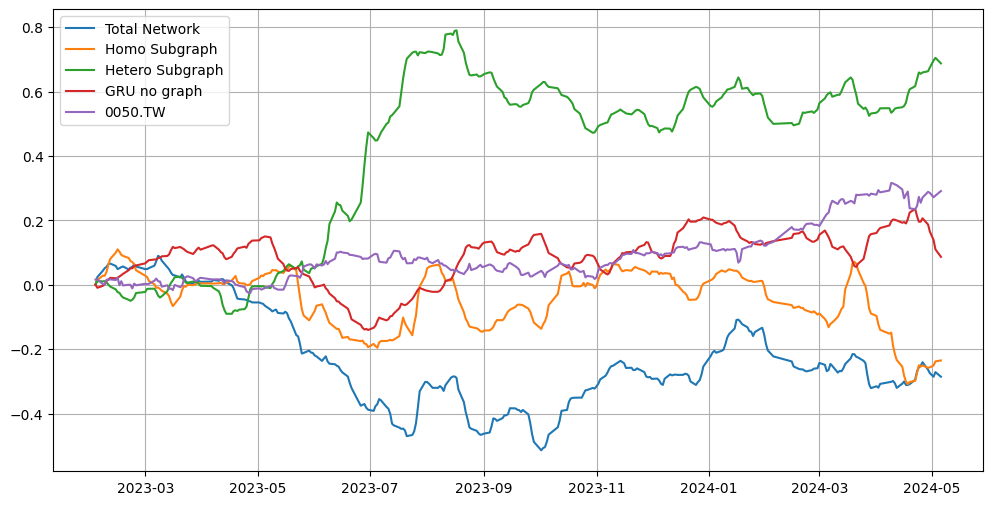

In [38]:
num = 5
cumreturns_total = longshort(model_complete, testing_dataloader, num, 'Total_Network.xlsx')
cumreturns_homo = longshort(model_homo, testing_dataloader, num, 'Homogeneous.xlsx')
cumreturns_hetero = longshort(model_hetero, testing_dataloader, num, 'Heterogeneous.xlsx')
#cumreturns_fs = longshort(model_fs, testing_dataloader, num, 'Total_Network.xlsx')
cumreturns_gru = longshort(model_gru, testing_dataloader, num)

time_index = data[f"{comp}"][data[f"{comp}"].index >= pd.to_datetime("2023")].iloc[previous_days - 1:  - prediction_days + 1].index
market_cumsum = data["0050"][data["0050"].index >= pd.to_datetime("2023")].iloc[previous_days - 1: - prediction_days + 1]['log return'].cumsum()
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(time_index, cumreturns_total, label = 'Total Network')
plt.plot(time_index, cumreturns_homo, label = 'Homo Subgraph')
plt.plot(time_index, cumreturns_hetero, label = 'Hetero Subgraph')
#plt.plot(time_index, cumreturns_fs, label = 'Total Network + Financial Statement')
plt.plot(time_index, cumreturns_gru, label = 'GRU no graph')
plt.plot(time_index, market_cumsum, label = '0050.TW')
plt.legend()


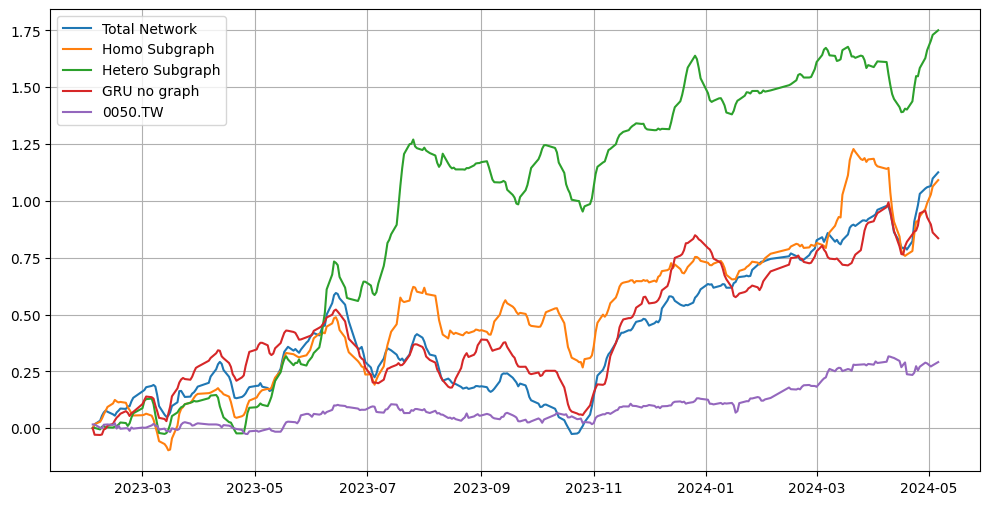

In [39]:
num = 5
cumreturns_total = long(model_complete, testing_dataloader, num, 'Total_Network.xlsx')
cumreturns_homo = long(model_homo, testing_dataloader, num, 'Homogeneous.xlsx')
cumreturns_hetero = long(model_hetero, testing_dataloader, num, 'Heterogeneous.xlsx')
#cumreturns_fs = long(model_fs, testing_dataloader, num, 'Total_Network.xlsx')
cumreturns_gru = long(model_gru, testing_dataloader, num)

time_index = data[f"{comp}"][data[f"{comp}"].index >= pd.to_datetime("2023")].iloc[previous_days - 1:  - prediction_days + 1].index
market_cumsum = data["0050"][data["0050"].index >= pd.to_datetime("2023")].iloc[previous_days - 1: - prediction_days + 1]['log return'].cumsum()
plt.figure(figsize = (12, 6))
plt.grid(True)
plt.plot(time_index, cumreturns_total, label = 'Total Network')
plt.plot(time_index, cumreturns_homo, label = 'Homo Subgraph')
plt.plot(time_index, cumreturns_hetero, label = 'Hetero Subgraph')
#plt.plot(time_index, cumreturns_fs, label = 'Total Network + Financial Statement')
plt.plot(time_index, cumreturns_gru, label = 'GRU no graph')
plt.plot(time_index, market_cumsum, label = '0050.TW')
plt.legend()
